In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'ray_tracing_synthesis')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
torch.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from model import build_net

from utils import remove_blind_region_psf0, remove_blind_region_psf7p5, remove_blind_region_minuspsf7p5,set_stateless_batchnorm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
import time
from time import sleep
from PIL import Image

from ray_tracing_synthesis import SoSToTimeShiftTransformer, image_to_sos_map

PARAM_SOS_BEAMFORMING = 1540
PARAM_SCALING_INPUT = 100000000
PARAM_SCALING_OUTPUT = 100
PARAM_BASE_OUTPUT = PARAM_SOS_BEAMFORMING
PARAM_NUMBER_OF_TRAINING_DATA = 1280000
PARAM_LEARNING_RATE = 0.0005
PARAM_WEIGHTDECAY = 0.3
EPOCH_NUM = 3
BATCH_SIZE = 32
GPU_BASE = 4
GPU_LIST_TO_PARALLEL = [GPU_BASE, 1,2,3] ### Specify the available GPU indices in your machine 
from worker_module import preparing_training_data  


data_parent_dir = (
    './untar_ImageNet_6_1/'
)

def eval_testingdata(model, test_data, test_label, criterion):
    outputs = (
        model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
        [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
        + PARAM_BASE_OUTPUT
    )
    loss = criterion(outputs, test_label.to(f"cuda:{GPU_BASE}", dtype=torch.float))
    print("RMSE in testing set is", torch.sqrt(loss.cpu()).detach().numpy())



import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# Prepare test data
transformer = SoSToTimeShiftTransformer()
sos_from_ImageNet = []
time_lag_from_ImageNet = []
for i in range(PARAM_NUMBER_OF_TRAINING_DATA+1, PARAM_NUMBER_OF_TRAINING_DATA+201):
    image = Image.open(f"{data_parent_dir}grayscale_cropped_{i}.JPEG")
    sos_map = image_to_sos_map(image)
    time_lag_from_ImageNet.append([
        remove_blind_region_psf7p5(transformer.transform(sos_map, "7p5psf")),
        remove_blind_region_psf0(transformer.transform(sos_map, "0psf")),
        remove_blind_region_minuspsf7p5(transformer.transform(sos_map, "minus7p5psf")),
    ])
    sos_from_ImageNet.append(sos_map[:, 19:-19])

test_data = torch.tensor(np.array(time_lag_from_ImageNet))
test_label = torch.tensor(np.array(sos_from_ImageNet)).unsqueeze(1)
del sos_from_ImageNet, time_lag_from_ImageNet


Class initializing, device is cuda


In [2]:
def visualize_test_data():
    fig, axs = plt.subplots(2, 6, figsize=(16, 6))
    outputs_test = (
            model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
            [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
            + PARAM_BASE_OUTPUT
        ).cpu().detach().numpy()

    for i in range(2):
        for j in range(6):
            # Example: Plot a sine wave with a different phase in each subplot
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + (i * 4 + j))
            if i == 0:
                im = axs[i, j].imshow(test_label[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Ground Truth")
            if i == 1:
                im = axs[i, j].imshow(outputs_test[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Reconstructed")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            cbar = fig.colorbar(im, ax=axs[i, j])
            cbar.set_label("SoS [m/s]",fontsize = 13)

    plt.tight_layout()
    plt.show()

Elapsed time = 21.805402278900146
batch 1 / 40000
running_loss = 4460.9949951171875
batch_loss = 4003.931396484375
queue length = 3986
RMSE in testing set is 62.75764


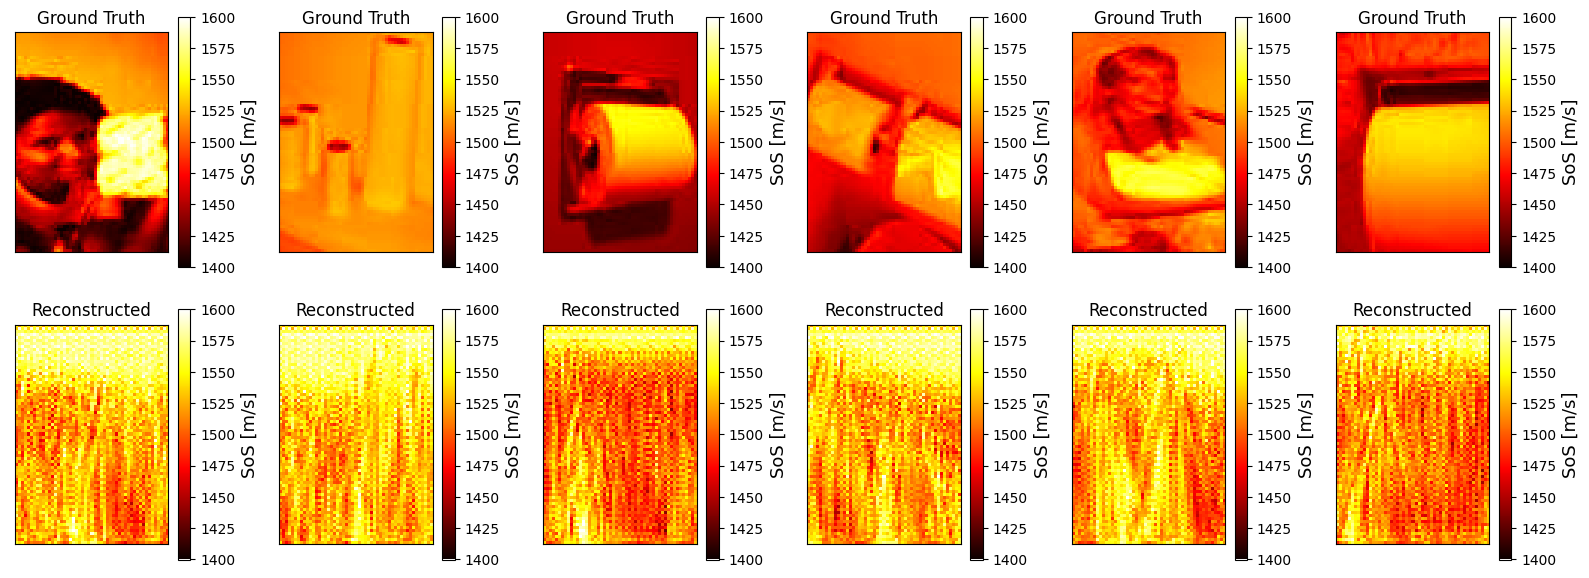

Elapsed time = 74.67639803886414
batch 1001 / 40000
running_loss = 1298.541648088101
batch_loss = 915.346435546875
queue length = 366
RMSE in testing set is 26.430235
Elapsed time = 85.23590588569641
batch 2001 / 40000
running_loss = 1096.2446093640247
batch_loss = 1028.6380615234375
queue length = 256
RMSE in testing set is 24.925524


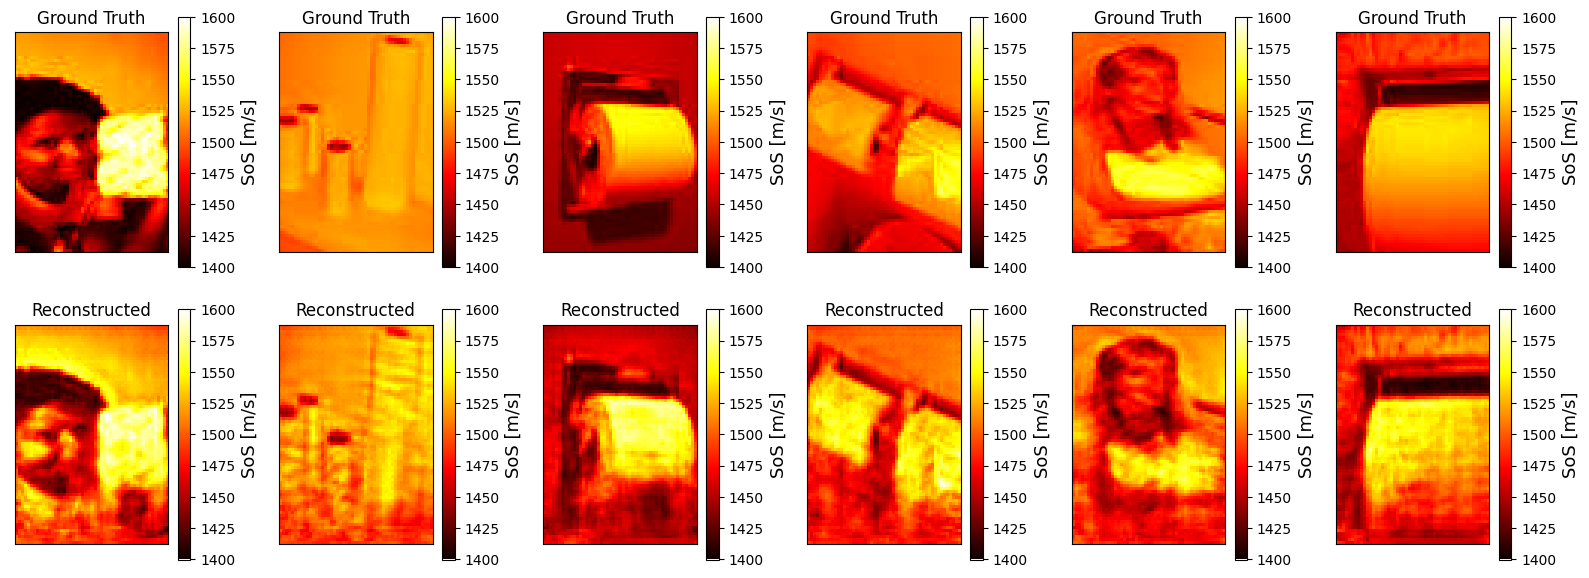

Elapsed time = 85.02453517913818
batch 3001 / 40000
running_loss = 987.5510300668694
batch_loss = 699.88134765625
queue length = 146
RMSE in testing set is 23.239521
Elapsed time = 85.25512385368347
batch 4001 / 40000
running_loss = 914.4547512696898
batch_loss = 705.8650512695312
queue length = 366
RMSE in testing set is 23.015224


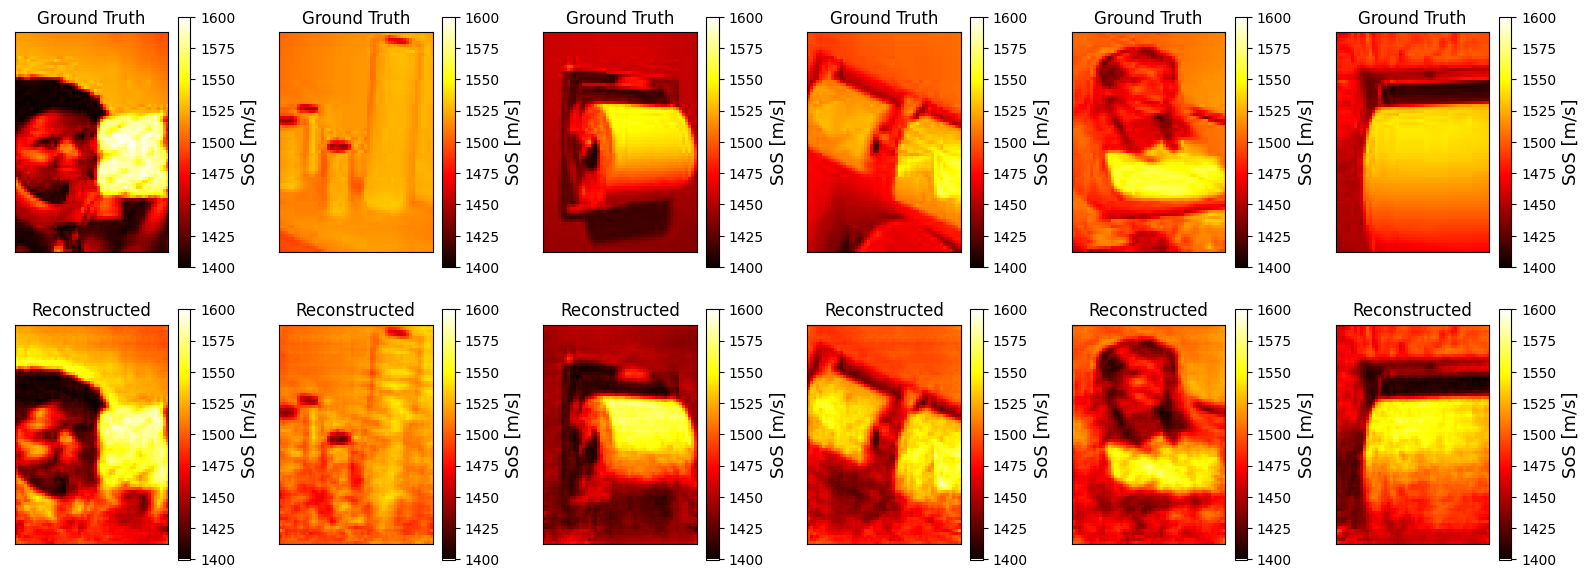

Elapsed time = 85.36029982566833
batch 5001 / 40000
running_loss = 859.794697697093
batch_loss = 523.4619750976562
queue length = 166
RMSE in testing set is 20.827166
Elapsed time = 85.28367209434509
batch 6001 / 40000
running_loss = 816.8770420998583
batch_loss = 616.3380126953125
queue length = 386
RMSE in testing set is 21.046713


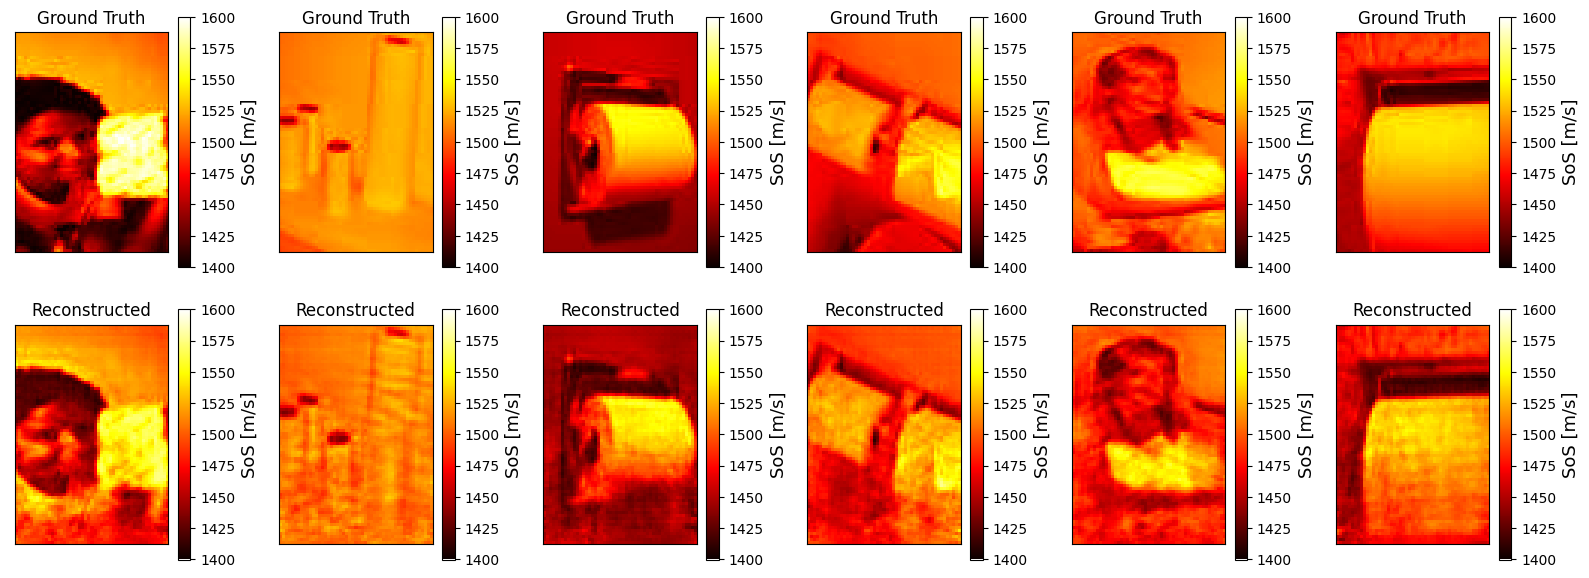

Elapsed time = 85.85283041000366
batch 7001 / 40000
running_loss = 781.7390293839386
batch_loss = 485.19580078125
queue length = 366
RMSE in testing set is 21.498144
Elapsed time = 83.88829755783081
batch 8001 / 40000
running_loss = 752.7422511933357
batch_loss = 571.9169921875
queue length = 406
RMSE in testing set is 19.079512


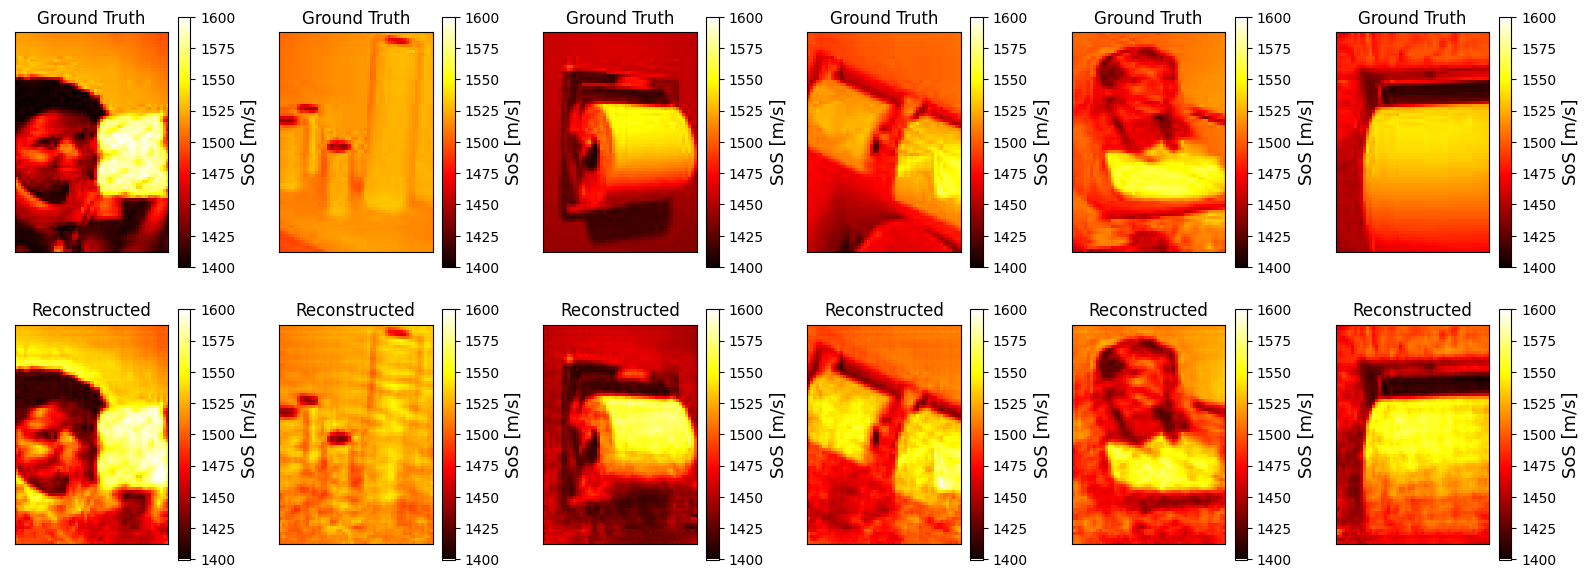

Elapsed time = 85.20883417129517
batch 9001 / 40000
running_loss = 727.3691552905235
batch_loss = 532.857421875
queue length = 206
RMSE in testing set is 18.576962
Elapsed time = 85.06968784332275
batch 10001 / 40000
running_loss = 704.9118066309834
batch_loss = 454.1597900390625
queue length = 186
RMSE in testing set is 17.567322


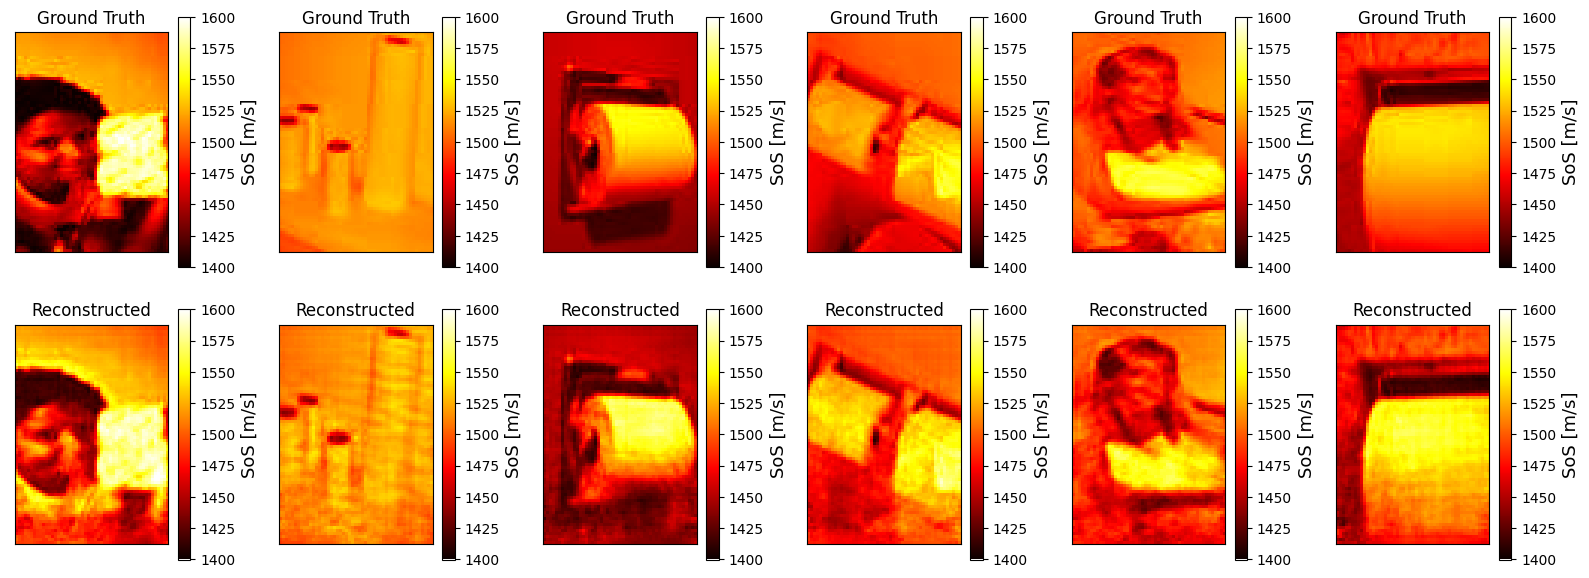

Elapsed time = 86.29831147193909
batch 11001 / 40000
running_loss = 685.2828539203588
batch_loss = 558.64697265625
queue length = 196
RMSE in testing set is 17.003906
Elapsed time = 88.29406929016113
batch 12001 / 40000
running_loss = 667.5185006219057
batch_loss = 442.6040344238281
queue length = 356
RMSE in testing set is 17.913603


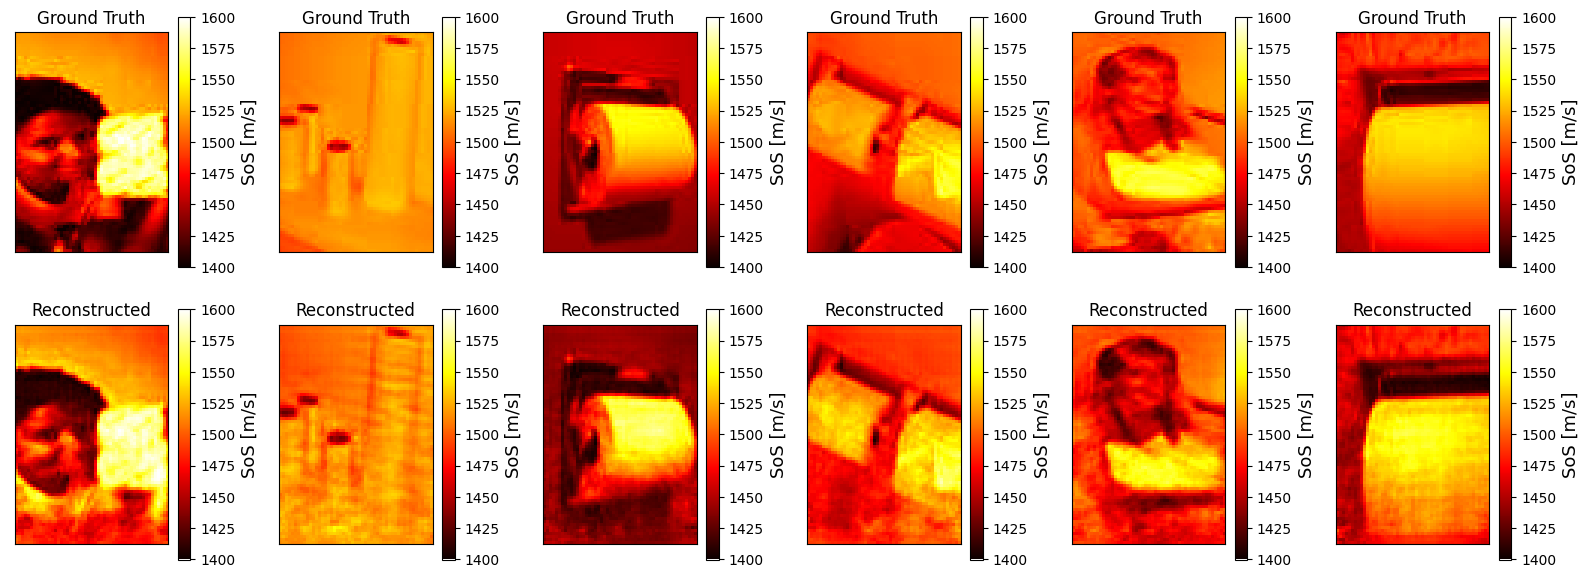

Elapsed time = 83.23671841621399
batch 13001 / 40000
running_loss = 651.8824374731862
batch_loss = 434.64044189453125
queue length = 186
RMSE in testing set is 18.74109
Elapsed time = 85.70150947570801
batch 14001 / 40000
running_loss = 637.2116078361922
batch_loss = 464.5379943847656
queue length = 76
RMSE in testing set is 19.971764


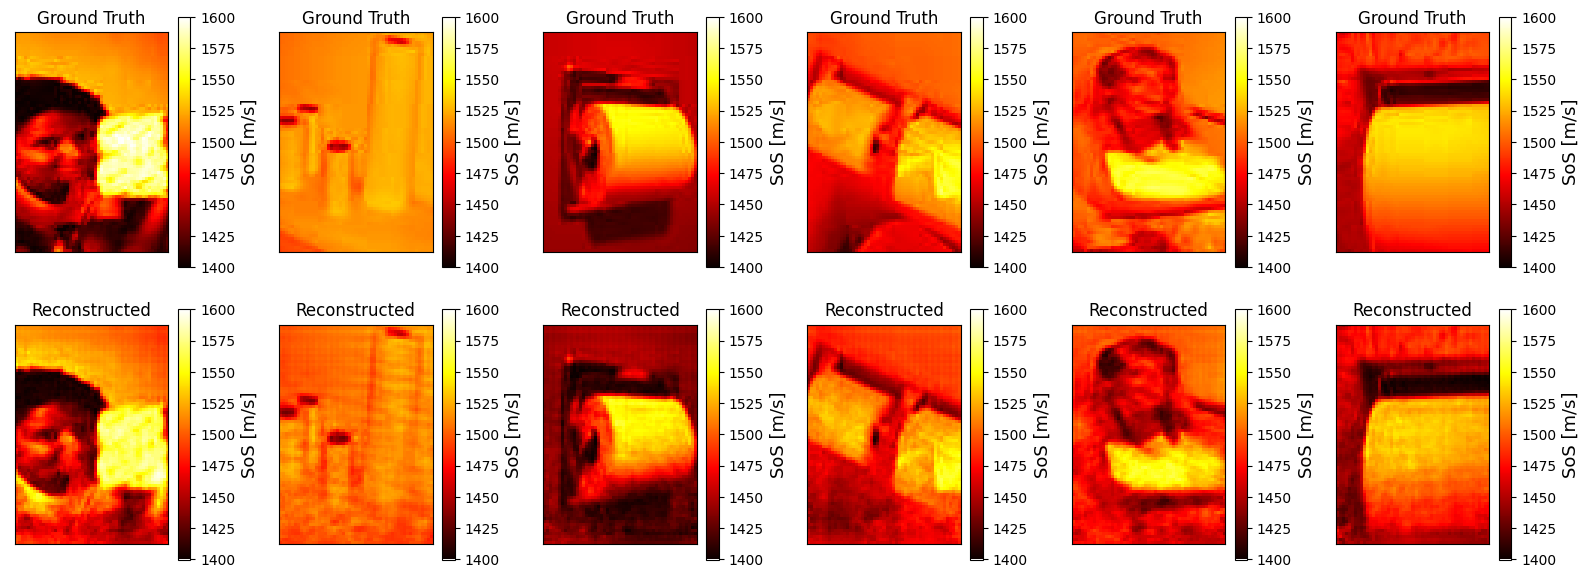

Elapsed time = 84.94236159324646
batch 15001 / 40000
running_loss = 624.1838125623777
batch_loss = 499.1644592285156
queue length = 26
RMSE in testing set is 16.579548
Elapsed time = 86.47520279884338
batch 16001 / 40000
running_loss = 611.8627539054108
batch_loss = 378.3607482910156
queue length = 186
RMSE in testing set is 15.720455


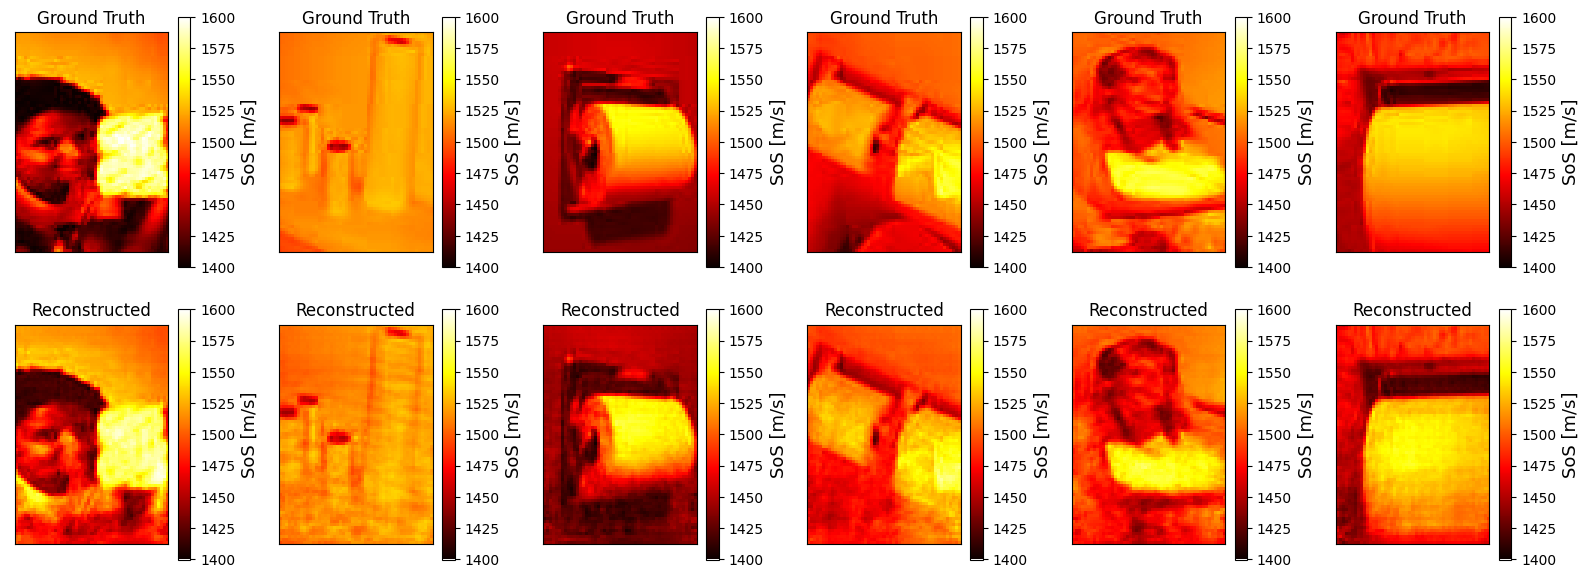

Elapsed time = 86.54407572746277
batch 17001 / 40000
running_loss = 600.8337340310607
batch_loss = 445.9373474121094
queue length = 136
RMSE in testing set is 16.032063
Elapsed time = 85.62232875823975
batch 18001 / 40000
running_loss = 590.617367671021
batch_loss = 381.6112365722656
queue length = 116
RMSE in testing set is 16.340096


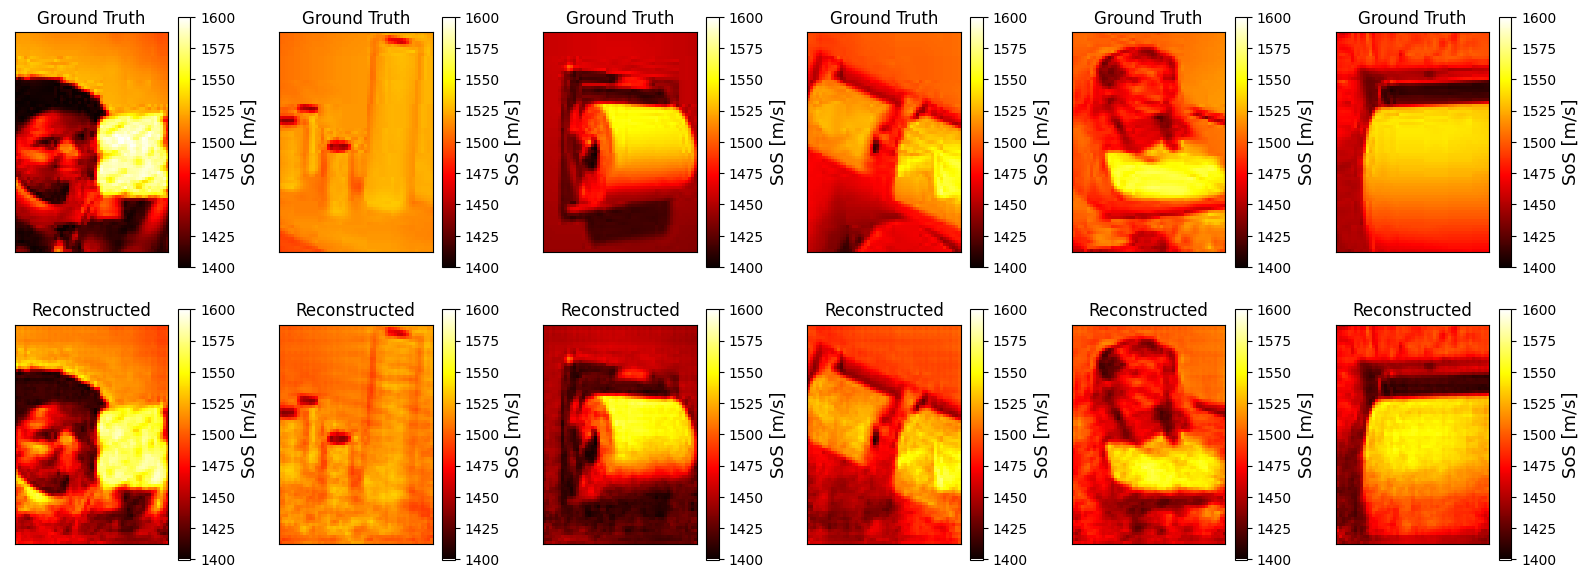

Elapsed time = 86.6015682220459
batch 19001 / 40000
running_loss = 580.9542077107375
batch_loss = 353.9705505371094
queue length = 396
RMSE in testing set is 16.310862
Elapsed time = 83.60070085525513
batch 20001 / 40000
running_loss = 571.9655754349492
batch_loss = 420.7999572753906
queue length = 16
RMSE in testing set is 16.54335


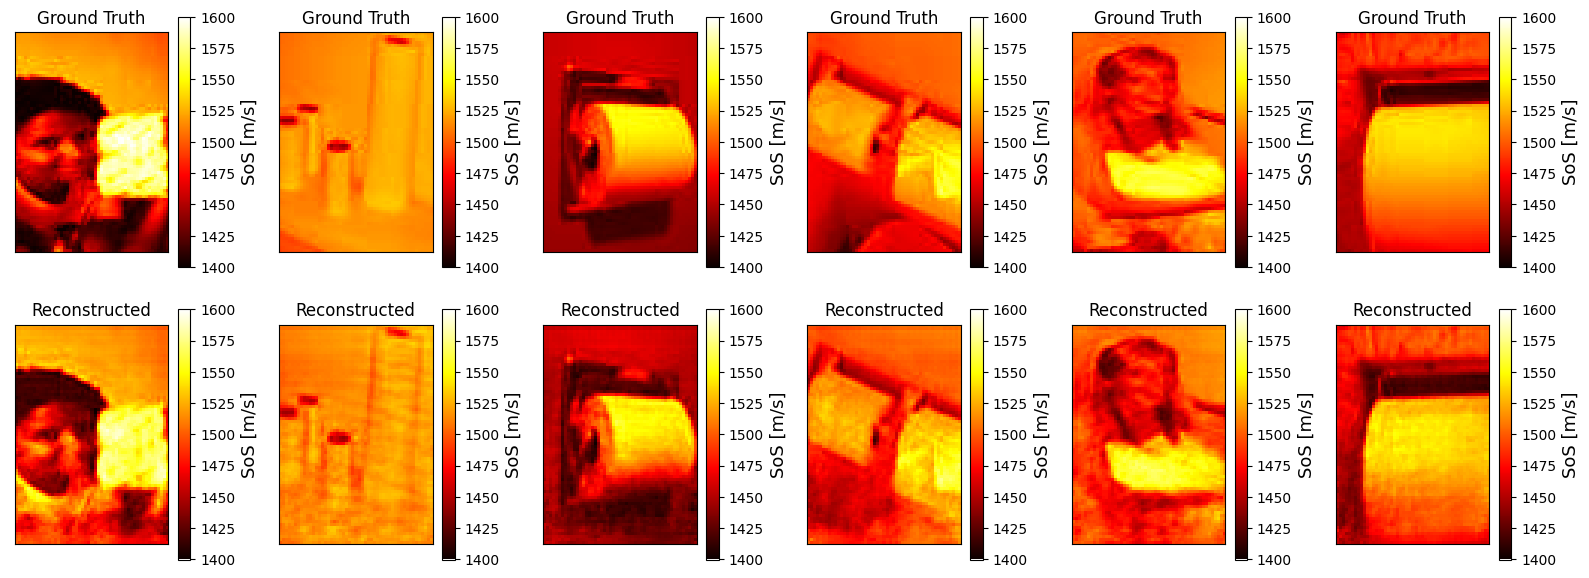

Elapsed time = 85.32855677604675
batch 21001 / 40000
running_loss = 563.5305148884746
batch_loss = 410.8049011230469
queue length = 266
RMSE in testing set is 16.67929
Elapsed time = 86.22053456306458
batch 22001 / 40000
running_loss = 555.5618396429959
batch_loss = 583.1506958007812
queue length = 216
RMSE in testing set is 15.871456


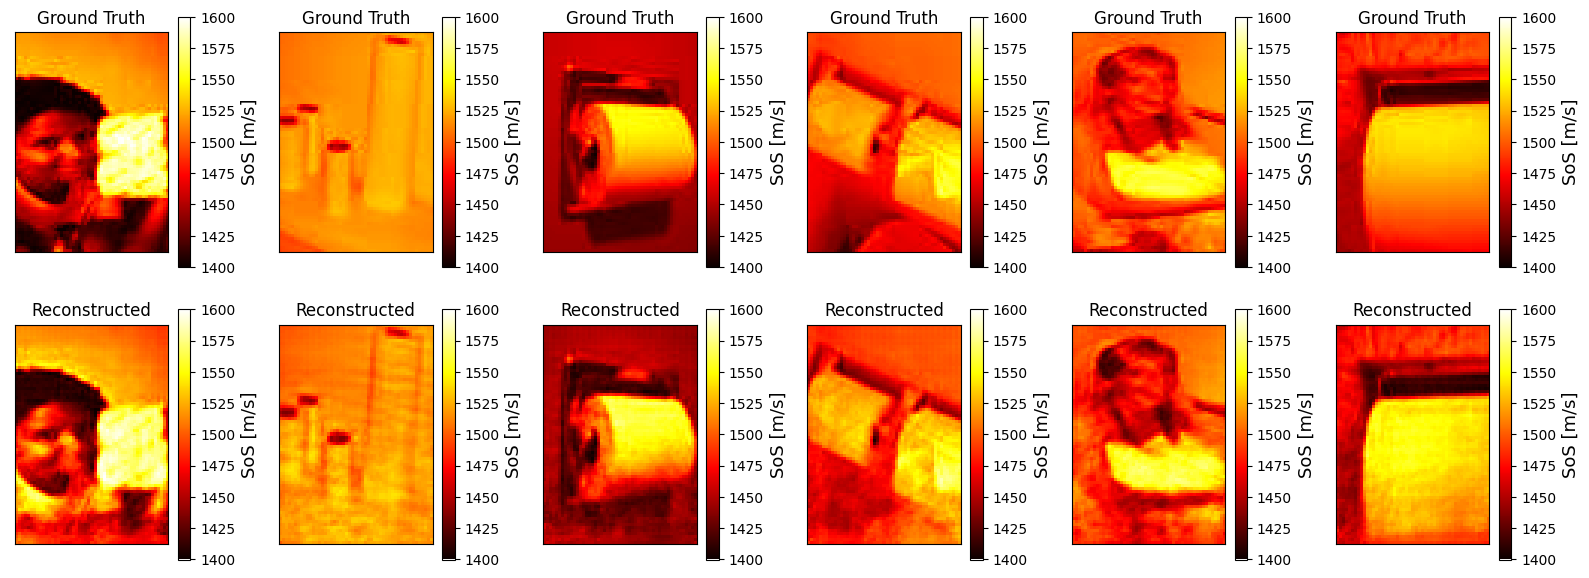

Elapsed time = 84.56714677810669
batch 23001 / 40000
running_loss = 548.1682042549013
batch_loss = 371.17083740234375
queue length = 76
RMSE in testing set is 15.422181
Elapsed time = 84.49303698539734
batch 24001 / 40000
running_loss = 541.071530199937
batch_loss = 298.2630920410156
queue length = 116
RMSE in testing set is 15.433566


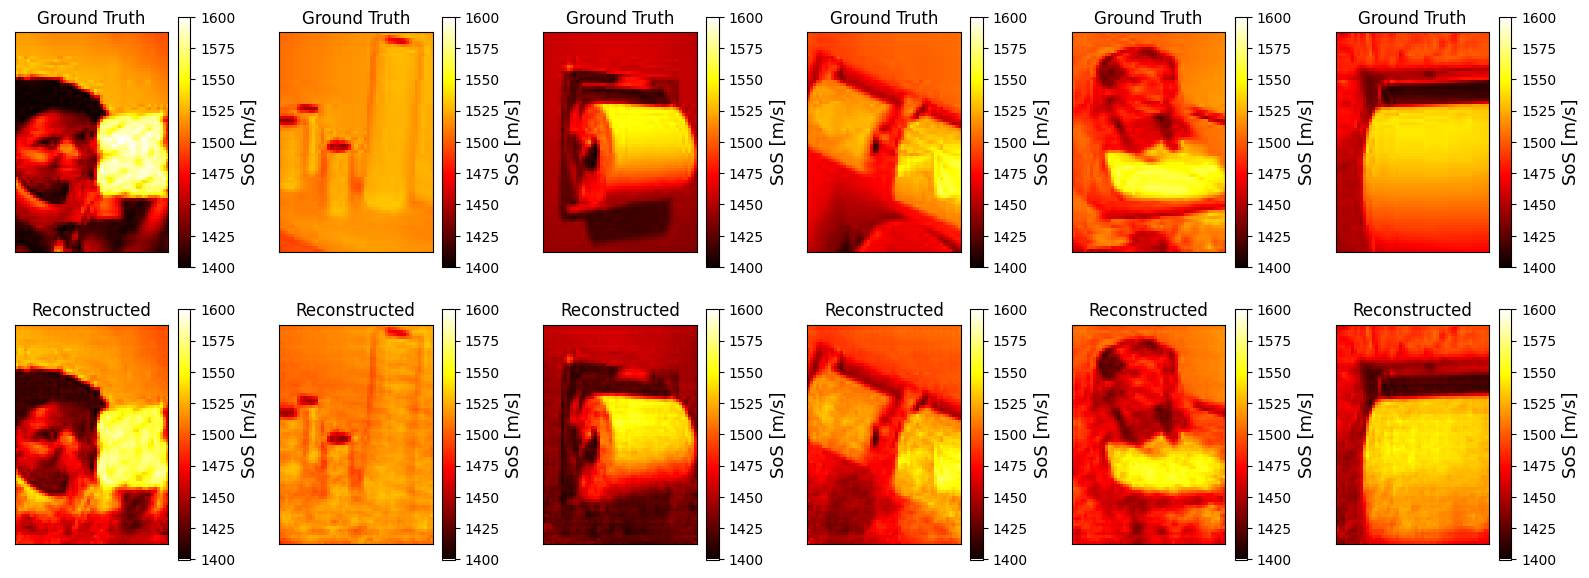

Elapsed time = 84.8253436088562
batch 25001 / 40000
running_loss = 534.4531901174713
batch_loss = 382.42236328125
queue length = 66
RMSE in testing set is 15.477981
Elapsed time = 86.74040389060974
batch 26001 / 40000
running_loss = 528.2700118208727
batch_loss = 462.0962829589844
queue length = 166
RMSE in testing set is 14.504341


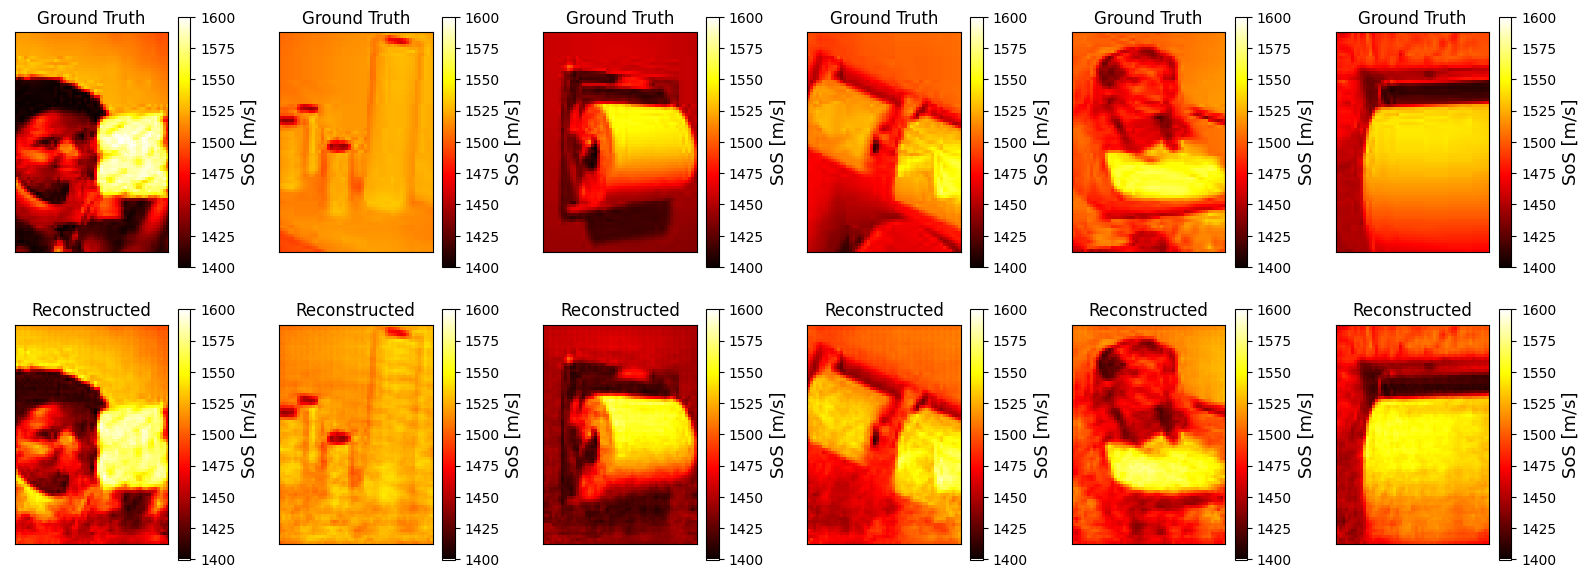

In [ ]:
model = build_net().to(f"cuda:{GPU_BASE}")
model = nn.DataParallel(model, device_ids=GPU_LIST_TO_PARALLEL)
model.train()
set_stateless_batchnorm(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAM_LEARNING_RATE, weight_decay=PARAM_WEIGHTDECAY)

manager = mp.Manager()
shared_queue_time_lag = manager.list()
shared_lock_1, shared_lock_2 = mp.Lock(), mp.Lock()
idx_list_init = list(range(PARAM_NUMBER_OF_TRAINING_DATA))
random.shuffle(idx_list_init)
img_idx_tobe_loaded = manager.list(idx_list_init)


processes = [
    mp.Process(
        target=preparing_training_data,
        args=(
            shared_lock_1,
            shared_lock_2,
            img_idx_tobe_loaded,
            shared_queue_time_lag,
            PARAM_NUMBER_OF_TRAINING_DATA,
            4000,
            data_parent_dir,  # <--- Pass the data dir to the worker
        ),
    )
    for _ in range(3)
]
for p in processes:
    p.start()
    sleep(1)

LEN_TRAINING_DATA = PARAM_NUMBER_OF_TRAINING_DATA
last_time_stamp = time.time()
for epoch_i in range(EPOCH_NUM):
    running_loss = 0.0
    for batch_i in range(LEN_TRAINING_DATA // BATCH_SIZE):
        batch_data_np, batch_label_np = [], []
        for _ in range(BATCH_SIZE):
            while len(shared_queue_time_lag) == 0:
                sleep(1)
            time_lag_np, sos_np = shared_queue_time_lag.pop()
            batch_data_np.append(time_lag_np * PARAM_SCALING_INPUT)
            batch_label_np.append(sos_np)

        batch_data = torch.from_numpy(np.stack(batch_data_np)).to(f"cuda:{GPU_BASE}", dtype=torch.float)
        batch_label = torch.from_numpy(np.stack(batch_label_np)).unsqueeze(1).to(f"cuda:{GPU_BASE}", dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(
            outputs[:, :, :, 19:-19] * PARAM_SCALING_OUTPUT + PARAM_BASE_OUTPUT,
            batch_label[:, :, :, 19:-19],
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_i % 1000 == 1:
            print("Elapsed time =", time.time() - last_time_stamp)
            last_time_stamp = time.time()
            print(f"batch {batch_i} / {LEN_TRAINING_DATA // BATCH_SIZE}")
            print("running_loss =", running_loss / (batch_i + 1))
            print("batch_loss =", loss.item())
            print("queue length =", len(shared_queue_time_lag))

            from datetime import datetime
            current_date = datetime.now().strftime("%Y_%m_%d")
            ckpt_name = (
                f"./pre_trained_model_d{current_date}_parametric_3_input_beamforming_SoS_"
                f"{PARAM_SOS_BEAMFORMING}_output_base_{PARAM_BASE_OUTPUT}_NumberOfTraningData_"
                f"{PARAM_NUMBER_OF_TRAINING_DATA}_learning_rate_{PARAM_LEARNING_RATE}_"
                f"PARAM_WEIGHTDECAY_{PARAM_WEIGHTDECAY}_no_batch_norm.pt"
            )
            torch.save(model.module.state_dict(), ckpt_name)
            model.eval()
            eval_testingdata(model, test_data, test_label, criterion)
            if batch_i % 2000 == 1:
                visualize_test_data()
            model.train()

    print(f"Epoch {epoch_i + 1}/{EPOCH_NUM} finished. "
          f"Average loss: {running_loss / (LEN_TRAINING_DATA / BATCH_SIZE)}")
